# Initialization

In [ ]:
import torch
from torch.utils import data as data_
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch.nn.functional as F
from torch.utils.data import random_split


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
use_gpu = torch.cuda.is_available()

!pip install torchsummary
!pip install thop

# Parameters
EPOCH = 50
lr = 0.001

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Validation split and dataloader

In [ ]:
BATCH_SIZE = 64

# dataset for training and validation
dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())



# split dataset into trainset and validset
torch.manual_seed(43)     # 確保每次獲得相同的驗證集
valid_size = 6000       # 取5000張驗證集(0.1 of dataset)
train_size = len(dataset) - valid_size
trainset, validset = random_split(dataset, [train_size, valid_size])

# dataset for testing
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True,drop_last=True, num_workers=2)   #生成batch 
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True,drop_last=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False,drop_last=True, num_workers=2)

print("dataset length: ", len(dataset))
print("train length: ", len(trainset))
print("val length: ", len(validset))
print("test length: ", len(testset))

dataset length:  60000
train length:  54000
val length:  6000
test length:  10000


# CNN

In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self.conv = nn.Conv2d(1, 32, 3)
        self.dropout = nn.Dropout2d(0.25)
        self.fc = nn.Linear(5408, 10)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        output = F.log_softmax(x, dim=1)
        return output

# Parameters summary

In [ ]:
from thop import profile

model = MnistModel().cuda()
input1 = torch.randn(1,1,28,28).cuda() 
MACs, params = profile(model, inputs=(input1, ))
print('MACs = ' + str(MACs/1000**3) + 'G')
print('Params = ' + str(params/1000**2) + 'M')

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
MACs = 0.000248768G
Params = 0.05441M


# Train

In [ ]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_sch

net = MnistModel().cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)   # momentum-SGD，採用L2正則化（權重衰減）
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=1, epochs=EPOCH)

train_loss, train_acc = [], []
val_loss, val_acc = [], []
lrs = []

for epoch in range(EPOCH):
    # train
    net.train()
    sum1_loss, sum2_loss = 0.0, 0.0
    correct = 0.0
    total = 0.0
    print('\nEpoch: %d' % (epoch + 1))
    for i, traindata in enumerate(trainloader, 0):
        # prepare data
        inputs, train_labels = traindata
        inputs, train_labels = inputs.to(device), train_labels.to(device)
        optimizer.zero_grad()

        # forward + backward
        train_outputs = net(inputs)
        trainloss = criterion(train_outputs, train_labels)
        trainloss.backward()
        optimizer.step()

        # 每訓練1個batch的loss和acc
        sum1_loss += trainloss.item()
        _, predicted = torch.max(train_outputs.data, 1)     # 取得分數最高的那個類 (outputs.data的index)
        total += train_labels.size(0)
        correct += predicted.eq(train_labels.data).cpu().sum()

    # learning rate schedule
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    #writer.add_scalar("lr", optimizer.param_groups[0]['lr'], epoch)
    #adjust_learning_rate(optimizer, epoch)
    print("learning rate: ",  optimizer.param_groups[0]['lr'])
    
    loss1 = sum1_loss / (i + 1)
    acc1 = correct / total
    print("Train loss: %.3f | Train acc: %.3f" % (loss1, acc1))
    train_loss.append(loss1)
    train_acc.append(acc1.item())

    # 用val驗證
    with torch.no_grad():
        correct = 0
        total = 0
        for j, valdata in enumerate(validloader, 0):
            net.eval()
            images, val_labels = valdata
            images, val_labels = images.to(device), val_labels.to(device)
            val_outputs = net(images)
            valloss = criterion(val_outputs, val_labels)
                    
            sum2_loss += valloss.item()
            _, predicted = torch.max(val_outputs.data, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum()
                
        loss2 = sum2_loss / (j + 1)
        acc2 = correct / total
        print("Val loss: %.3f | Val acc: %.3f" % (loss2, acc2))
        val_loss.append(loss2)
        val_acc.append(acc2.item())




Epoch: 1
learning rate:  0.0052034602152724735
Train loss: 0.584 | Train acc: 0.797
Val loss: 0.404 | Val acc: 0.863

Epoch: 2
learning rate:  0.008753494340683884
Train loss: 0.403 | Train acc: 0.860
Val loss: 0.362 | Val acc: 0.877

Epoch: 3
learning rate:  0.014472088841534572
Train loss: 0.371 | Train acc: 0.871
Val loss: 0.338 | Val acc: 0.881

Epoch: 4
learning rate:  0.022072489510780793
Train loss: 0.350 | Train acc: 0.877
Val loss: 0.313 | Val acc: 0.890

Epoch: 5
learning rate:  0.03117358052235722
Train loss: 0.333 | Train acc: 0.884
Val loss: 0.339 | Val acc: 0.885

Epoch: 6
learning rate:  0.04131899517009691
Train loss: 0.327 | Train acc: 0.884
Val loss: 0.340 | Val acc: 0.879

Epoch: 7
learning rate:  0.052000000000000005
Train loss: 0.315 | Train acc: 0.888
Val loss: 0.323 | Val acc: 0.886

Epoch: 8
learning rate:  0.0626810048299031
Train loss: 0.311 | Train acc: 0.889
Val loss: 0.323 | Val acc: 0.890

Epoch: 9
learning rate:  0.07282641947764279
Train loss: 0.306 | T

# Test accuracy

In [ ]:
# 用test測試
with torch.no_grad():
    correct = 0
    total = 0
    sum3_loss = 0.0
    for k, testdata in enumerate(testloader, 0):
        net.eval()
        imgs, test_labels = testdata
        imgs, test_labels = imgs.to(device), test_labels.to(device)
        test_outputs = net(imgs)
        testloss = criterion(test_outputs, test_labels)
                    
        sum3_loss += testloss.item()
        _, predicted = torch.max(test_outputs.data, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum()
                
    loss3 = sum3_loss / (k + 1)
    acc3 = correct / total
    print("Test loss: %.3f | Test acc: %.3f" % (loss3, acc3))

Test loss: 0.272 | Test acc: 0.907


# Plot

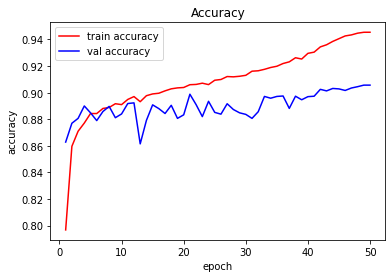

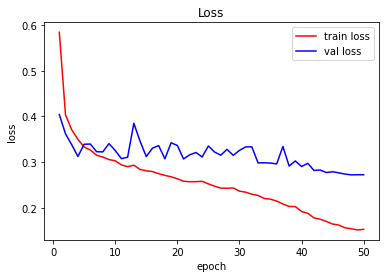

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
# plot accuracy curve
plt.figure(0)
plt.plot(range(1,EPOCH+1,1), np.array(train_acc), 'r-', label= "train accuracy") 
plt.plot(range(1,EPOCH+1,1), np.array(val_acc), 'b-', label= "val accuracy")
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()
# plot loss curve
plt.figure(1)
plt.plot(range(1,EPOCH+1,1), np.array(train_loss), 'r-', label= "train loss") 
plt.plot(range(1,EPOCH+1,1), np.array(val_loss), 'b-', label= "val loss")
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()